# Introduction

Your objective is to forecast the inventory levels for each product over the next 13 weeks, starting from the cutoff date of May 7, 2023.

This part of the interview will consist of the following four steps:

1. **Exploratory Data Analysis**
   - Visualization of target variable
   - Distribution of covariates
   - Correlations

2. **Data Preparation**
   - Ensure data quality

3. **Feature Engineering**
   - Generate features for forecasting

4. **Forecasting**
   - Predict inventory for last 13 weeks

5. **Evaluation**
   - Calculate accuracy

# Schema

| Column Name       | Description                                                                                     |
|-------------------|-------------------------------------------------------------------------------------------------|
| id                | An identifier for each time series, composed of yearweek + product_number. Example: 202301-1234567. |
| date              | The date in the format YYYY-MM-DD.                                                              |
| yearweek          | The year and week in the format YYYYWW.                                                         |
| product_number    | A unique identifier for each product.                                                           |
| reporterhq_id     | A unique identifier for each reseller (vendor).                                                 |
| prod_category     | The product category, which groups products from the same product line. (Often humorous names.) |
| specs             | Specifications of the product, such as RAM, graphics card, or other components.                 |
| segment           | The target segment of the product.                                                              |
| sales_units       | The number of units sold to the final customer for that week.                                   |
| **inventory_units**   | The target variable, representing the inventory for each product_number and reporterhq_id for a specific week. |


# Setup

In [1]:
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import lightgbm as lgb
import seaborn as sns
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor

sns.set_theme(style="darkgrid")

# Load data

In [46]:
file_path = 'train_v_2_kaggle_23.csv'
df_kaggle = pd.read_csv(file_path)
df_kaggle.head()

,id,date,year_week,product_number,reporterhq_id,prod_category,specs,display_size,segment,sales_units,inventory_units
0,202224-2961,2022-06-18,202224,2961,15,Doraemon,186631,15.6,Gaming,52.0,88.0
1,202225-2961,2022-06-25,202225,2961,15,Doraemon,186631,15.6,Gaming,6.0,88.0
2,202226-2961,2022-07-02,202226,2961,15,Doraemon,186631,15.6,Gaming,60.0,138.0
3,202227-2961,2022-07-09,202227,2961,15,Doraemon,186631,15.6,Gaming,158.0,65.0
4,202228-2961,2022-07-16,202228,2961,15,Doraemon,186631,15.6,Gaming,23.0,30.0


## Formatting

In [47]:
# Convert specified columns to desired types
df_kaggle['date'] = pd.to_datetime(df_kaggle['date'], format='%Y-%m-%d', errors='coerce')
df_kaggle['sales_units'] = pd.to_numeric(df_kaggle['sales_units'], errors='coerce')
df_kaggle['inventory_units'] = pd.to_numeric(df_kaggle['inventory_units'], errors='coerce')

# Create a new column 'sku' by concatenating 'reporterhq_id' and 'product_number'
df_kaggle['sku'] = df_kaggle['reporterhq_id'].astype(str) + "_" + df_kaggle['product_number'].astype(str)

In [48]:
# Column "spec" is useless: there is a 1:1 relationship between "spec" and "product_number" 
# we will drop it
is_unique_col1_to_col2 = df_kaggle.groupby('specs')['product_number'].nunique().max() == 1
is_unique_col2_to_col1 = df_kaggle.groupby('product_number')['specs'].nunique().max() == 1
assert is_unique_col1_to_col2 and is_unique_col2_to_col1

df_kaggle.drop(columns=['specs'], inplace=True)

In [49]:
categorical_columns = ['id', 'product_number', 'reporterhq_id', 'prod_category', 'display_size', 'segment', 'sku']
for col in categorical_columns:
    df_kaggle[col] = df_kaggle[col].astype('category')

In [50]:
df_kaggle.dtypes

id                       category
date               datetime64[ns]
year_week                   int64
product_number           category
reporterhq_id            category
prod_category            category
display_size             category
segment                  category
sales_units               float64
inventory_units           float64
sku                      category
dtype: object

## Metadata

In [51]:
# Count the number of NaNs in each column of the DataFrame
nan_counts = df_kaggle.isna().sum()

# Display the NaN counts
print(nan_counts)

id                   0
date                 0
year_week            0
product_number       0
reporterhq_id        0
prod_category        0
display_size         0
segment              0
sales_units        497
inventory_units    500
sku                  0
dtype: int64


In [52]:
df_kaggle = df_kaggle.sort_values(by='date')

# Exploratory Data Analysis

## Categorical columns


- __product_number__ 233 distinct values
- __reporterhq_id__ 20 distinct values
- __prod_category__ 7 distinct values
- __display_size__ 9 distinct values
- __segment__ 3 distinct values
- __sku__ 506 distinct values

In [53]:
df_kaggle['segment'].value_counts()

segment
Core       12682
Premium     6242
Gaming      6215
Name: count, dtype: int64

In [54]:
df_kaggle['prod_category'].value_counts()

prod_category
Clover      7115
Goku        5424
Arale       4078
Doraemon    3455
Luffy       2044
Conan       2043
Bobobo       980
Name: count, dtype: int64

In [55]:
df_kaggle['display_size'].value_counts()

display_size
15.6    9793
17.3    4485
14.0    4417
13.3    3206
16.1    1926
13.5     876
11.0     292
11.6      97
12.0      47
Name: count, dtype: int64

- The same __reportehq_id__ is linked to multiple __product_number__
- Vice versa a __product_number__ is associated with multiple __reportehq_id__ 

Therefore the __id__ (yearweek + - + product_number. Unique identifier of the time series) is not unique
```
df_kaggle[df_kaggle['id']=='202225-4935']
```

In [56]:
# Reporterhq_id vs num_distinct_products
df_num_distinct_products = pd.DataFrame(df_kaggle.groupby('reporterhq_id')['product_number'].nunique())
df_count_entries = pd.DataFrame(df_kaggle['reporterhq_id'].value_counts())
df_reporterhq = df_num_distinct_products.merge(
    df_count_entries, 
    left_index=True, 
    right_index=True
    ).sort_values('product_number', ascending=False).rename(columns={'product_number': 'num_distinct_products', 'count': 'num_entries'})

/var/folders/0b/l6j0p2ks77sdrd0y2c4876p40000gn/T/ipykernel_25892/186212025.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_num_distinct_products = pd.DataFrame(df_kaggle.groupby('reporterhq_id')['product_number'].nunique())


In [57]:
df_reporterhq

,num_distinct_products,num_entries
reporterhq_id,,
93,93,4212
15,92,3836
24,47,3893
3,45,3462
21,35,1563
12,29,1589
78,29,1988
90,28,1447
6,24,420


In [58]:
df_kaggle[df_kaggle['id']=='202225-4935']

,id,date,year_week,product_number,reporterhq_id,prod_category,display_size,segment,sales_units,inventory_units,sku
171,202225-4935,2022-06-25,202225,4935,93,Arale,13.3,Premium,0.0,33.0,93_4935
170,202225-4935,2022-06-25,202225,4935,15,Arale,13.3,Premium,0.0,87.0,15_4935


## Visualization

### Visualize sales and inventory by segment

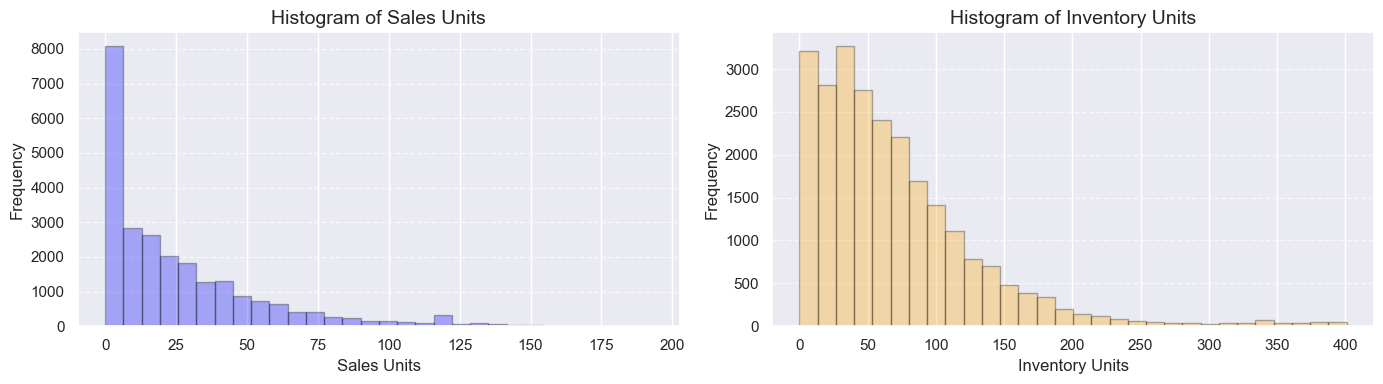

In [59]:
# Plot histograms for sales_units and inventory_units
plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
df_kaggle['sales_units'].dropna().plot(kind='hist', bins=30, color='blue', edgecolor='black', alpha=0.3)
plt.title('Histogram of Sales Units', fontsize=14)
plt.xlabel('Sales Units', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(1, 2, 2)
df_kaggle['inventory_units'].dropna().plot(kind='hist', bins=30, color='orange', edgecolor='black', alpha=0.3)
plt.title('Histogram of Inventory Units', fontsize=14)
plt.xlabel('Inventory Units', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

/var/folders/0b/l6j0p2ks77sdrd0y2c4876p40000gn/T/ipykernel_25892/2089930465.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for ax, (name, data) in zip(g.axes.flat, df_kaggle.groupby("segment")):


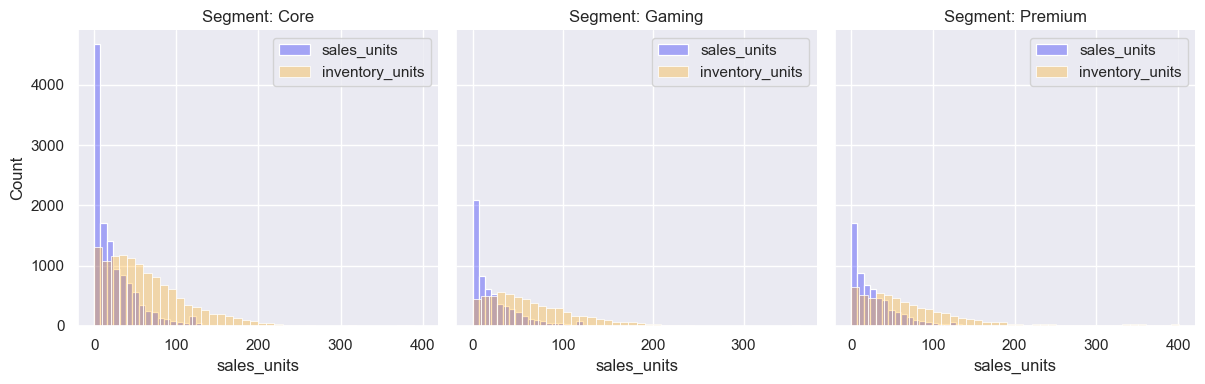

In [60]:
g = sns.FacetGrid(df_kaggle, col="segment", col_wrap=4, sharex=False, sharey=True, height=4)

for ax, (name, data) in zip(g.axes.flat, df_kaggle.groupby("segment")):
    sns.histplot(data['sales_units'], ax=ax, kde=False, color='blue', alpha=0.3, label='sales_units', bins=25)
    sns.histplot(data['inventory_units'], ax=ax, kde=False, color='orange', alpha=0.3, label='inventory_units', bins=40)
    ax.legend()

g.set_titles("Segment: {col_name}")
plt.tight_layout()
plt.show()

In [61]:
df_kaggle.head()

,id,date,year_week,product_number,reporterhq_id,prod_category,display_size,segment,sales_units,inventory_units,sku
22680,201915-233919,2019-04-13,201915,233919,3,Clover,15.6,Core,2.0,20.0,3_233919
22681,201916-233919,2019-04-20,201916,233919,3,Clover,15.6,Core,4.0,43.0,3_233919
22683,201917-233919,2019-04-27,201917,233919,24,Clover,15.6,Core,1.0,110.0,24_233919
22682,201917-233919,2019-04-27,201917,233919,3,Clover,15.6,Core,121.0,74.0,3_233919
22685,201918-233919,2019-05-04,201918,233919,24,Clover,15.6,Core,12.0,120.0,24_233919


<Axes: title={'center': 'Total Sales and Inventory Units per Day'}, xlabel='date'>

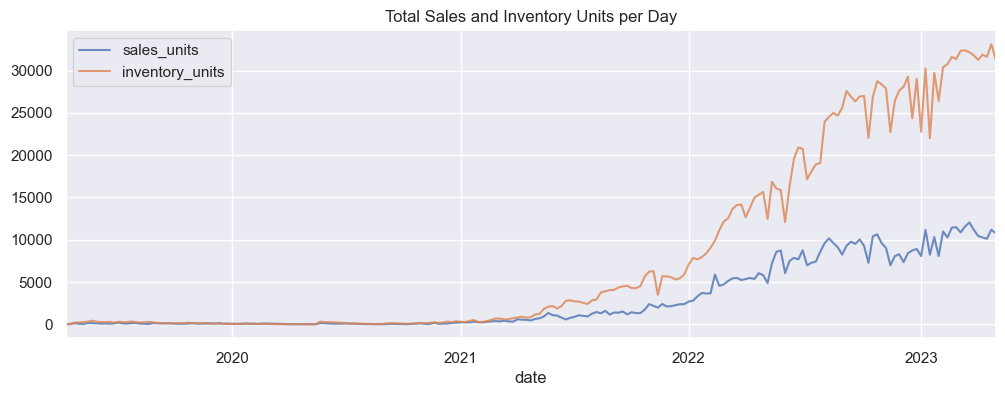

In [62]:
df_kaggle.groupby('date')[['sales_units', 'inventory_units']].sum().plot(
    figsize=(12, 4), title='Total Sales and Inventory Units per Day', alpha=0.8)

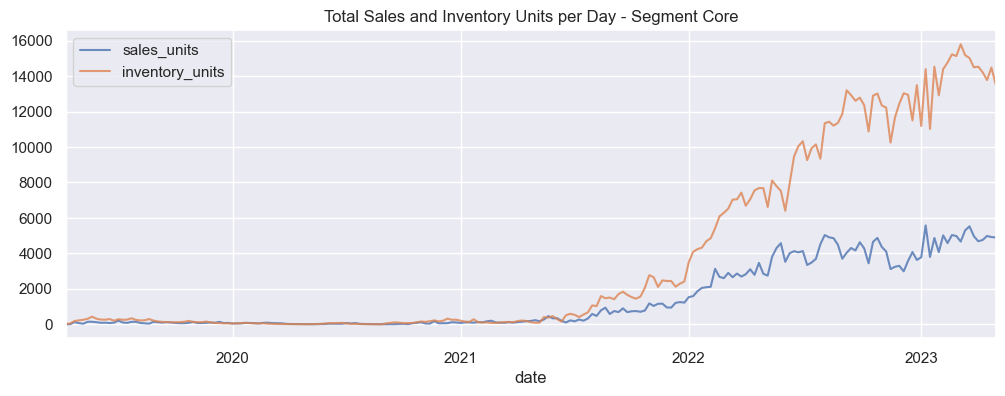

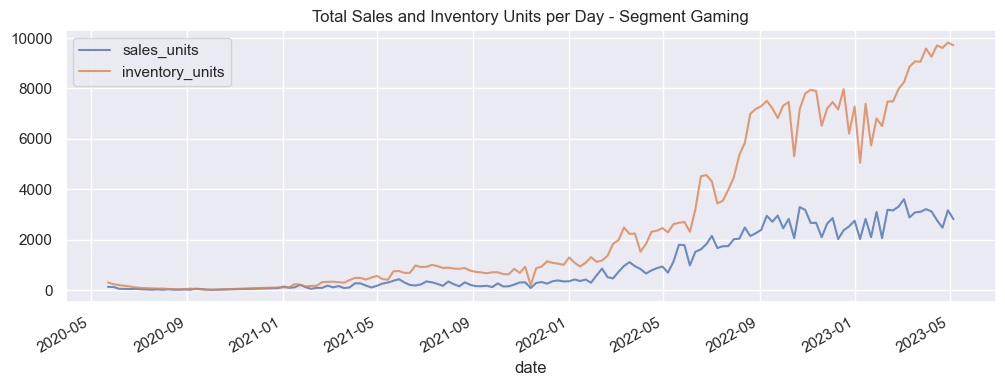

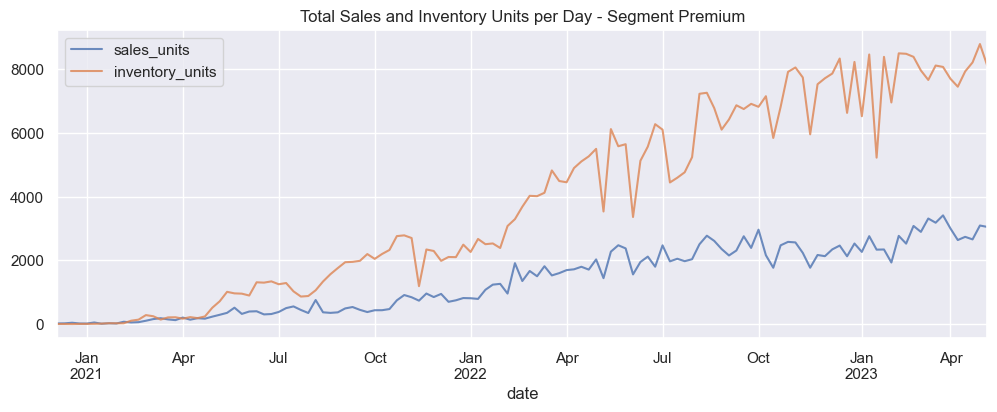

In [63]:
for segment in df_kaggle['segment'].unique():
    segment_data = df_kaggle[df_kaggle['segment'] == segment]
    segment_data.groupby('date')[['sales_units', 'inventory_units']].sum().plot(
        figsize=(12, 4), 
        title=f"Total Sales and Inventory Units per Day - Segment {segment}",
        alpha=0.8
    )

plt.show()

## Distribution

Evaluate distribution of covariates

/var/folders/0b/l6j0p2ks77sdrd0y2c4876p40000gn/T/ipykernel_25892/3343472918.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for ax, (name, data) in zip(g.axes.flat, df_kaggle.groupby("prod_category")):


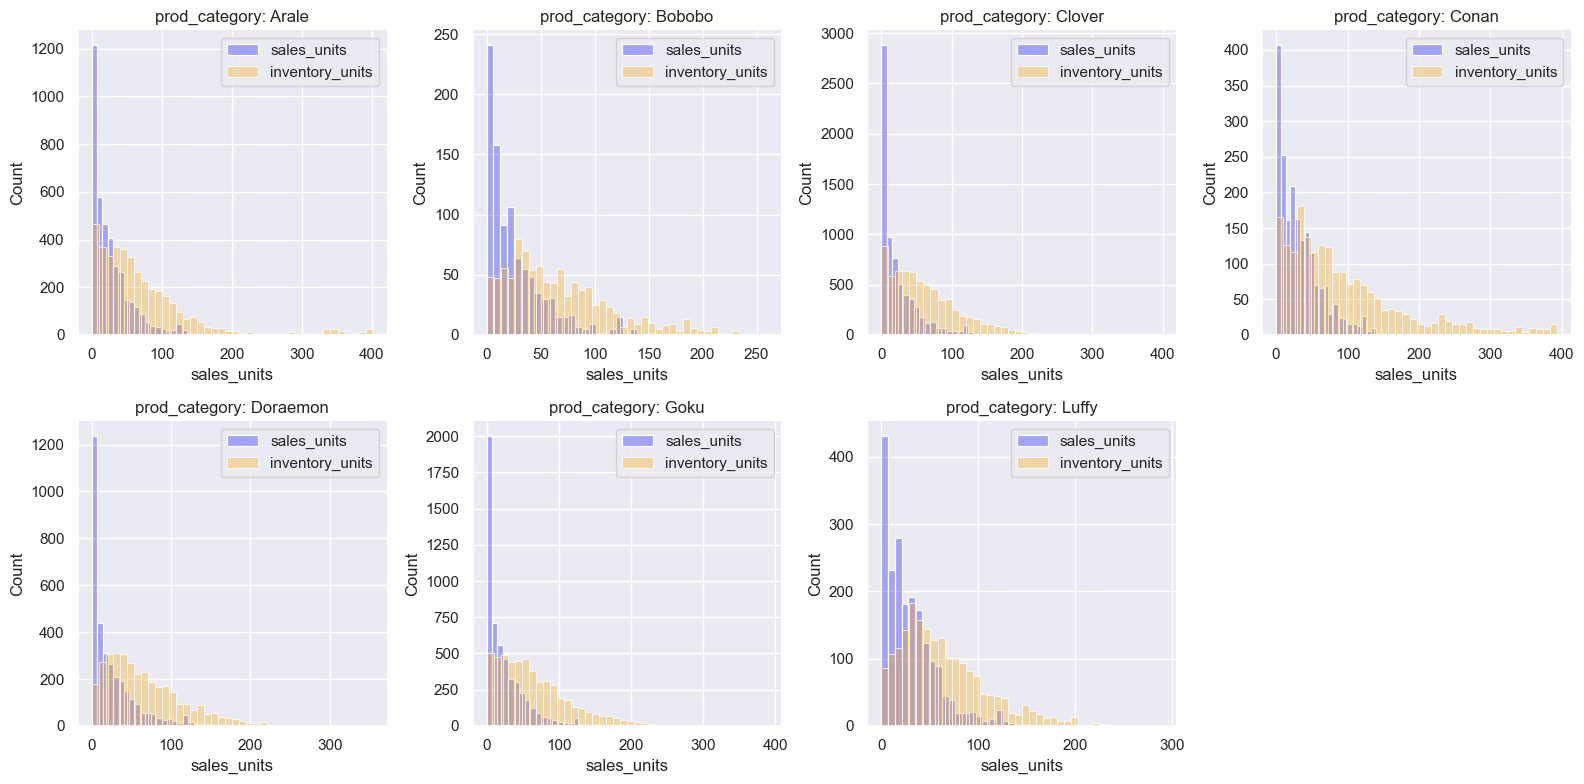

In [64]:
g = sns.FacetGrid(df_kaggle, col="prod_category", col_wrap=4, sharex=False, sharey=False, height=4)

for ax, (name, data) in zip(g.axes.flat, df_kaggle.groupby("prod_category")):
    sns.histplot(data['sales_units'], ax=ax, kde=False, color='blue', alpha=0.3, label='sales_units', bins=25)
    sns.histplot(data['inventory_units'], ax=ax, kde=False, color='orange', alpha=0.3, label='inventory_units', bins=40)
    ax.legend()

g.set_titles("prod_category: {col_name}")
plt.tight_layout()
plt.show()

## Correlation

Hint: Sales should decrease the inventory in the same week.

In [65]:
df_daily = df_kaggle.groupby('date')[['sales_units', 'inventory_units']].sum()
df_daily["sales_units"].corr(df_daily["inventory_units"])

np.float64(0.9878540843553847)

In [66]:
correlation_list = []
for report_id in df_kaggle['reporterhq_id'].unique():
    df_daily = df_kaggle.copy()
    df_daily = df_daily[df_daily['reporterhq_id'] == report_id]
    df_daily = df_daily.groupby('date')[['sales_units', 'inventory_units']].sum()
    correlation = round(df_daily["sales_units"].corr(df_daily["inventory_units"]), 2)
    correlation_list.append((report_id, correlation))
    #print(f"Correlation for reporterhq_id {report_id}: {correlation}")

df_corr_by_reporterhq = pd.DataFrame(correlation_list, columns=['reporterhq_id', 'sales-inventory correlation']).set_index('reporterhq_id')

In [67]:
df_reporterhq.merge(df_corr_by_reporterhq, left_index=True, right_index=True)

,num_distinct_products,num_entries,sales-inventory correlation
reporterhq_id,,,
93,93,4212,0.87
15,92,3836,0.86
24,47,3893,0.91
3,45,3462,0.93
21,35,1563,0.86
12,29,1589,0.85
78,29,1988,0.91
90,28,1447,0.71
6,24,420,0.95


## Length time series

In [68]:
df_kaggle.head()

,id,date,year_week,product_number,reporterhq_id,prod_category,display_size,segment,sales_units,inventory_units,sku
22680,201915-233919,2019-04-13,201915,233919,3,Clover,15.6,Core,2.0,20.0,3_233919
22681,201916-233919,2019-04-20,201916,233919,3,Clover,15.6,Core,4.0,43.0,3_233919
22683,201917-233919,2019-04-27,201917,233919,24,Clover,15.6,Core,1.0,110.0,24_233919
22682,201917-233919,2019-04-27,201917,233919,3,Clover,15.6,Core,121.0,74.0,3_233919
22685,201918-233919,2019-05-04,201918,233919,24,Clover,15.6,Core,12.0,120.0,24_233919


<Axes: >

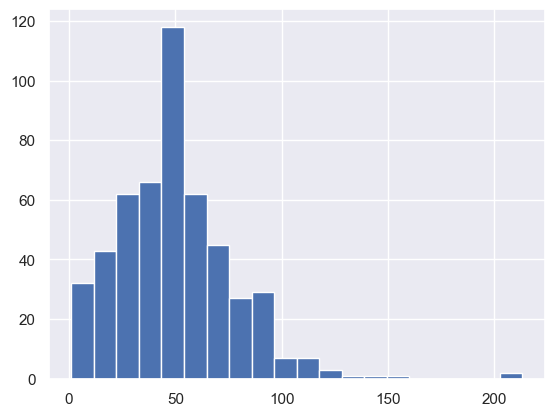

In [72]:
df_kaggle['sku'].value_counts().hist(bins=20)

In [81]:
sum(df_kaggle['sku'].value_counts() < 2)

4

In [82]:
temp = df_kaggle.copy().sort_values(by=['sku', 'date'])

# Step 2: Calculate time difference in weeks for consecutive rows within each ID
temp['week_gap'] = temp.groupby('sku')['date'].diff().dt.days // 7

/var/folders/0b/l6j0p2ks77sdrd0y2c4876p40000gn/T/ipykernel_25892/1160632685.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp['week_gap'] = temp.groupby('sku')['date'].diff().dt.days // 7


<Axes: >

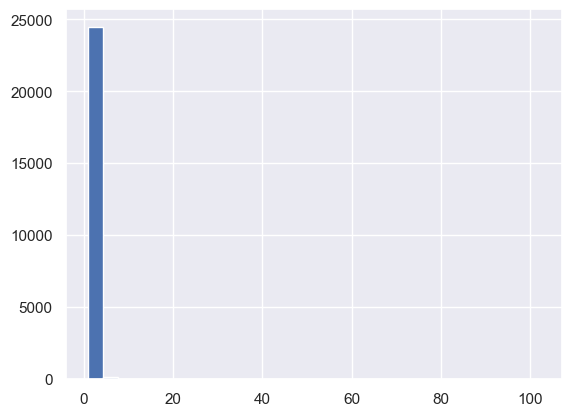

In [89]:
temp['week_gap'].hist(bins=30)

In [83]:
critical_gaps = temp[temp['week_gap'] > 4]

<Axes: >

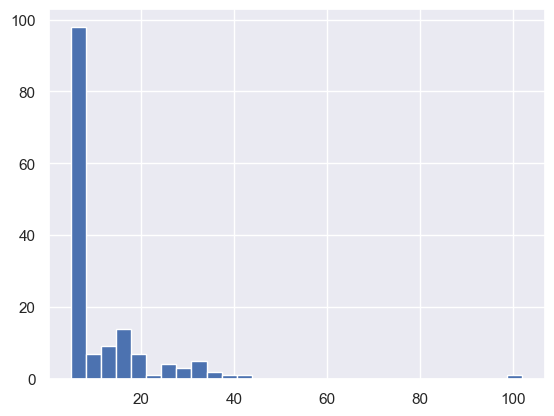

In [90]:
critical_gaps['week_gap'].hist(bins=30)

# Data preparation

## Fill NA records

Fill NA's by using some time series method for each SKU in the data

In [24]:
# Find the sku with the highest number of NaN values in sales_units
nan_counts_sku = df_kaggle[df_kaggle['sales_units'].isna()] \
    .groupby('sku')['sales_units'] \
    .size()

sku_with_most_nans = nan_counts_sku.idxmax()
df_sku = df_kaggle[df_kaggle['sku'] == '78_45402'].reset_index()
nan_counts_sku.sort_values(ascending=False).head(5)

/var/folders/0b/l6j0p2ks77sdrd0y2c4876p40000gn/T/ipykernel_25892/299985627.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('sku')['sales_units'] \


sku
78_45402     6
24_81921     5
15_188517    5
93_55272     5
3_97713      4
Name: sales_units, dtype: int64

In [25]:
sku_with_most_nans

'78_45402'

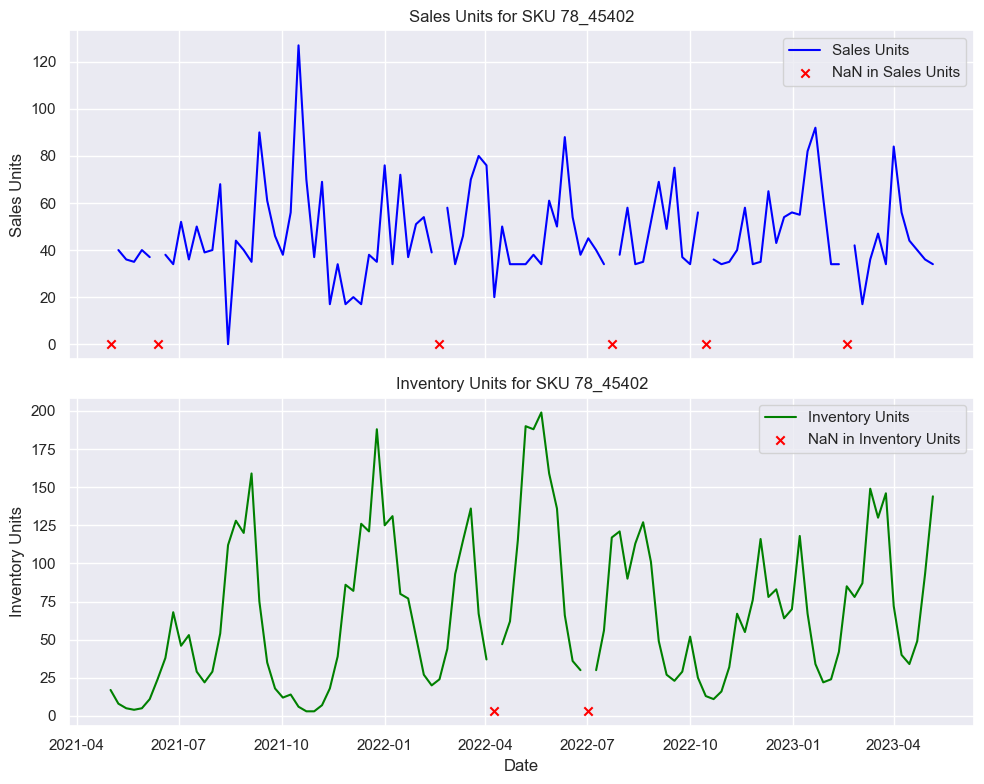

In [26]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot sales_units, highlighting NaN values
axes[0].plot(df_sku['date'], df_sku['sales_units'], color='blue', label='Sales Units')
axes[0].scatter(df_sku['date'][df_sku['sales_units'].isna()], 
                [df_sku['sales_units'].min()]*df_sku['sales_units'].isna().sum(),
                color='red', marker='x', label='NaN in Sales Units')
axes[0].set_title(f"Sales Units for SKU {sku_with_most_nans}")
axes[0].set_ylabel('Sales Units')
axes[0].legend()

# Plot inventory_units, highlighting NaN values
axes[1].plot(df_sku['date'], df_sku['inventory_units'], color='green', label='Inventory Units')
axes[1].scatter(df_sku['date'][df_sku['inventory_units'].isna()], 
                [df_sku['inventory_units'].min()]*df_sku['inventory_units'].isna().sum(),
                color='red', marker='x', label='NaN in Inventory Units')
axes[1].set_title(f"Inventory Units for SKU {sku_with_most_nans}")
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Inventory Units')
axes[1].legend()

plt.tight_layout()
plt.show()

Fill the NaN values seen above:

In [27]:
# Interpolation and fill-in function
def interpolate_sku(group):
    # Sort by date and interpolate sales_units
    group = group.sort_values(by='date')
    group = group.set_index('date')  
    group['sales_units'] = group['sales_units'].interpolate(method='time')
    group['inventory_units'] = group['inventory_units'].interpolate(method='time')
    return group.reset_index()

df_kaggle = df_kaggle.groupby('sku', group_keys=False).apply(interpolate_sku)

/var/folders/0b/l6j0p2ks77sdrd0y2c4876p40000gn/T/ipykernel_25892/1502501163.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_kaggle = df_kaggle.groupby('sku', group_keys=False).apply(interpolate_sku)
/var/folders/0b/l6j0p2ks77sdrd0y2c4876p40000gn/T/ipykernel_25892/1502501163.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_kaggle = df_kaggle.groupby('sku', group_keys=False).apply(interpolate_sku)


/var/folders/0b/l6j0p2ks77sdrd0y2c4876p40000gn/T/ipykernel_25892/652638422.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_dates_count = df_kaggle.groupby('sku')[['date']].count().sort_values(by='date', ascending=False)


array([[<Axes: title={'center': 'date'}>]], dtype=object)

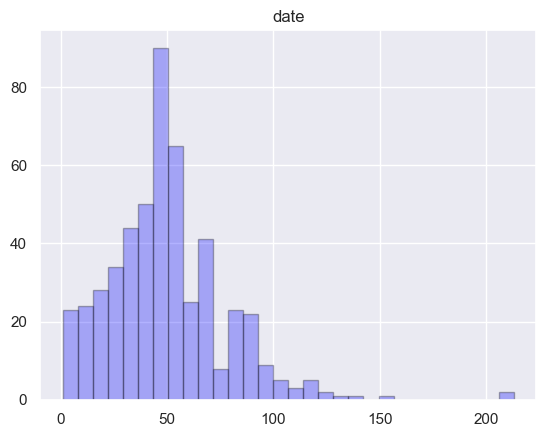

In [28]:
df_dates_count = df_kaggle.groupby('sku')[['date']].count().sort_values(by='date', ascending=False)
df_dates_count.hist(bins=30, color='blue', edgecolor='black', alpha=0.3)

In [29]:
df_dates_count['date'].describe()

count    506.000000
mean      49.681818
std       27.692933
min        1.000000
25%       32.000000
50%       47.000000
75%       64.000000
max      213.000000
Name: date, dtype: float64

# Feature Engineering

In [30]:
df_kaggle.head()

,date,id,year_week,product_number,reporterhq_id,prod_category,display_size,segment,sales_units,inventory_units,sku
0,2021-01-30,202104-10857,202104,10857,12,Doraemon,15.6,Gaming,0.0,52.0,12_10857
1,2021-02-06,202105-10857,202105,10857,12,Doraemon,15.6,Gaming,8.0,48.0,12_10857
2,2021-02-13,202106-10857,202106,10857,12,Doraemon,15.6,Gaming,39.0,72.0,12_10857
3,2021-02-20,202107-10857,202107,10857,12,Doraemon,15.6,Gaming,0.0,138.0,12_10857
4,2021-02-27,202108-10857,202108,10857,12,Doraemon,15.6,Gaming,69.0,87.0,12_10857


In [31]:
df_kaggle['date'].max()-pd.DateOffset(weeks=13)

Timestamp('2023-02-04 00:00:00')

In [32]:
df_kaggle['day_of_month'] = df_kaggle['date'].dt.day
df_kaggle['week_of_month'] = (df_kaggle['date'].dt.day - 1) // 7 + 1  # Week within the month
df_kaggle['week_of_year'] = df_kaggle['date'].dt.isocalendar().week  # ISO week number
df_kaggle['month_of_year'] = df_kaggle['date'].dt.month
df_kaggle['year'] = df_kaggle['date'].dt.year

In [33]:
# Define lags and lag column names
lags = [13]#[13, 14, 15]
lag_cols_inventory = [f"lag_{lag}_inventory" for lag in lags]
lag_cols_sales = [f"lag_{lag}_sales" for lag in lags]

# Generate lag columns for inventory_units
for lag, lag_col in zip(lags, lag_cols_inventory):
    df_kaggle[lag_col] = df_kaggle.groupby("sku", observed=False)["inventory_units"].shift(lag)

# Generate lag columns for sales_units
# for lag, lag_col in zip(lags, lag_cols_sales):
#     df_kaggle[lag_col] = df_kaggle.groupby("sku", observed=False)["sales_units"].shift(lag)

# Define the window sizes for rolling statistics (you can tweak these)
rolling_windows = [4]#[4, 8, 12]

# Function to generate rolling statistics
# def create_rolling_features(df, col, window_sizes, suffix):
#     for window in window_sizes:
        # Calculating rolling mean and rolling standard deviation for each `sku`
        # df[f'rolling_mean_{window}w_{suffix}'] = df.groupby('sku', observed=False)[col].transform(lambda x: x.shift(13).rolling(window, min_periods=1).mean())
        # df[f'rolling_std_{window}w_{suffix}'] = df.groupby('sku', observed=False)[col].transform(lambda x: x.shift(13).rolling(window, min_periods=1).std())
        # df[f'rolling_sum_{window}w_{suffix}'] = df.groupby('sku', observed=False)[col].transform(lambda x: x.shift(13).rolling(window, min_periods=1).sum())
    # return df

# Add rolling features for inventory and sales
# df_kaggle = create_rolling_features(df_kaggle, 'inventory_units', rolling_windows, 'inventory')
# df_kaggle = create_rolling_features(df_kaggle, 'sales_units', rolling_windows, 'sales')

# Forecasting

Use your favourite model to predict last 13 weeks for Gaming segment

In [36]:
# Filter Gaming segment

In [37]:
# TODO Train test split

# Take baseline from the notebooks in the competition

In [36]:
# Add code here
df = df_kaggle.copy()
df = df[df['segment'] == 'Premium'].rename(columns={'inventory_units': 'y'}).reset_index(drop=True).set_index('date')
dropped_columns = df[['y', 'id']]
X_train = df.drop(columns=dropped_columns)
y_train = df[["y"]]

In [37]:
lgb_params = {
    'boosting_type': 'gbdt',
    'class_weight': None,
    'colsample_bytree': np.float64(0.9914924607394691),
    'importance_type': 'split',
    'learning_rate': np.float64(0.027590738215604697),
    'max_depth': np.int64(10),
    'min_child_samples': 25,
    'min_child_weight': 0.034,
    'min_split_gain': 0.0,
    'n_estimators': 200,
    'n_jobs': None,
    'num_leaves': 157,
    'objective': 'regression',
    'random_state': 222,
    'reg_alpha': 0,
    'reg_lambda': 0,
    'subsample': np.float64(0.6006545748134953),
    'subsample_for_bin': 200000,
    'subsample_freq': 0,
    'bagging_fraction': 0.418,
    'bagging_seed': 11,
    'feature_fraction': 0.379,
    'metric': 'rmse',
    'min_data_in_leaf': 106,
    'verbosity': -1,
    }

In [38]:
model = LGBMRegressor(**lgb_params)
model.fit(X=X_train, y=y_train, categorical_feature=categorical_columns[1:])

LGBMRegressor(bagging_fraction=0.418, bagging_seed=11,
              colsample_bytree=np.float64(0.9914924607394691),
              feature_fraction=0.379,
              learning_rate=np.float64(0.027590738215604697),
              max_depth=np.int64(10), metric='rmse', min_child_samples=25,
              min_child_weight=0.034, min_data_in_leaf=106, n_estimators=200,
              num_leaves=157, objective='regression', random_state=222,
              reg_alpha=0, reg_lambda=0,
              subsample=np.float64(0.6006545748134953), verbosity=-1)

In [39]:
time_index = X_train.index.get_level_values(-1)
time_mask = time_index > time_index.max() - np.timedelta64(13, "W")
X_train_recent = X_train.loc[time_mask]
y_train_recent = y_train.loc[time_mask]

In [40]:
# Get in-sample predictions.
y_pred_train = model.predict(X=X_train_recent)

df_preds = pd.DataFrame(
    data={
        "sku": X_train_recent["sku"],
        "y_pred": y_pred_train,
        "y": y_train_recent['y']
    },
    index=X_train_recent.index
)

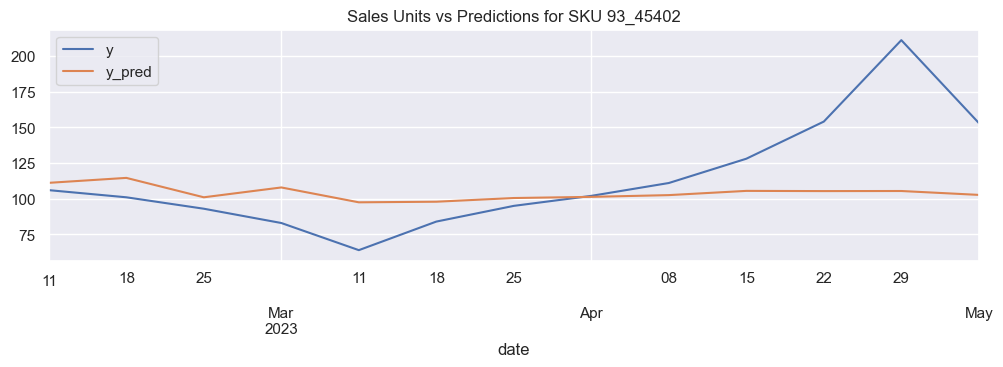

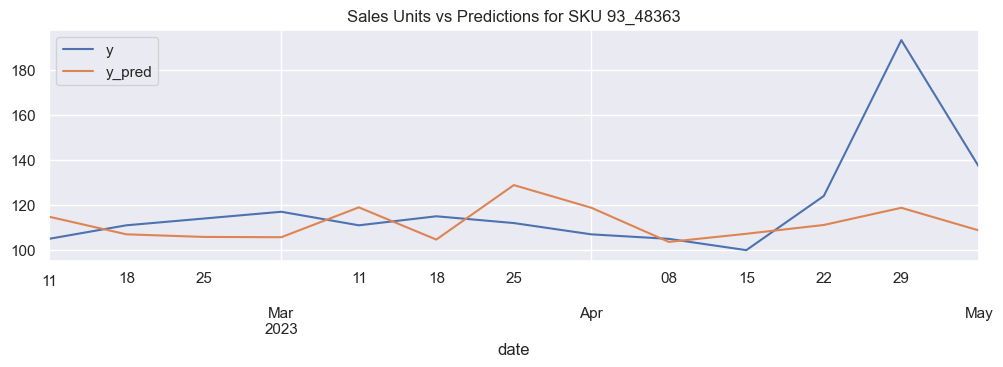

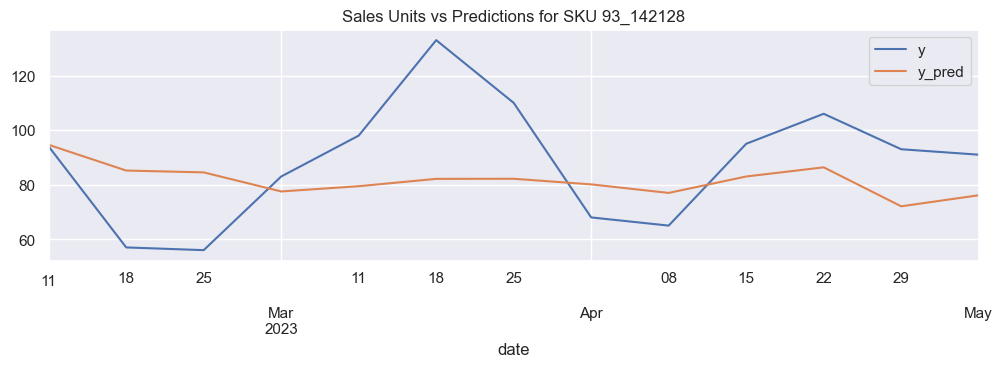

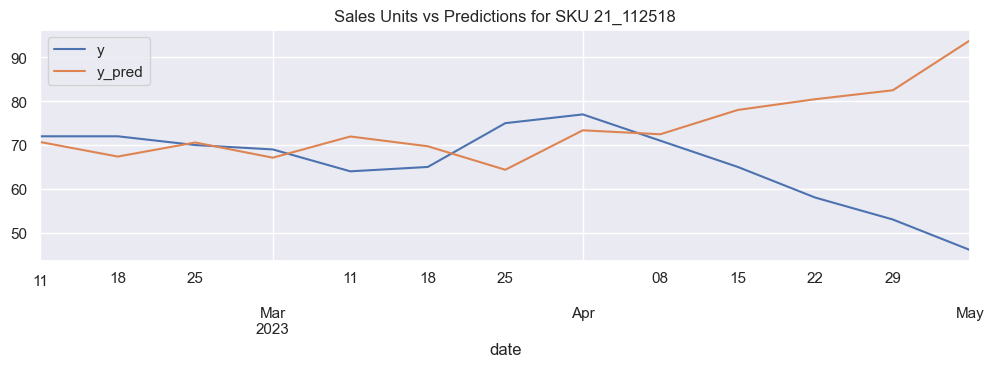

In [42]:
num_select = 4
random_skus = np.random.choice(df_preds['sku'].unique(), size=num_select, replace=False)

for sku in random_skus:
    df_preds[df_preds['sku'] == sku][['y', 'y_pred']].plot(figsize=(12, 3), title=f'Sales Units vs Predictions for SKU {sku}')

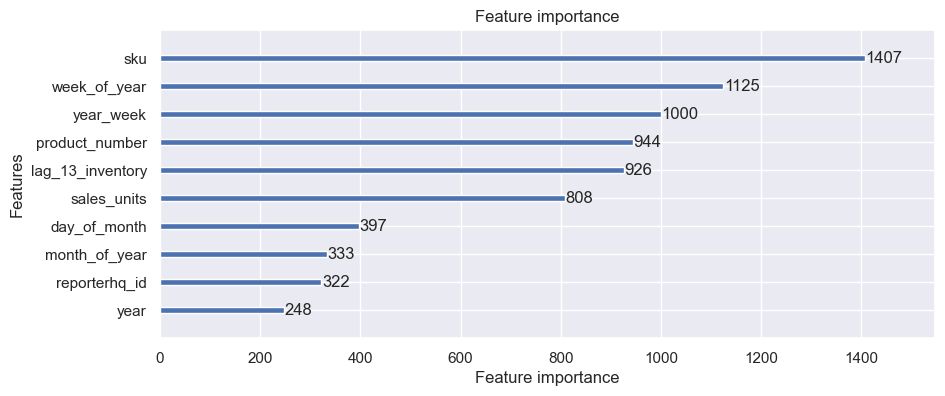

In [43]:
# Plot the feature importance based on "split" (how often a feature is used)
lgb.plot_importance(model, importance_type='split', max_num_features=10, figsize=(10, 4))
plt.show()

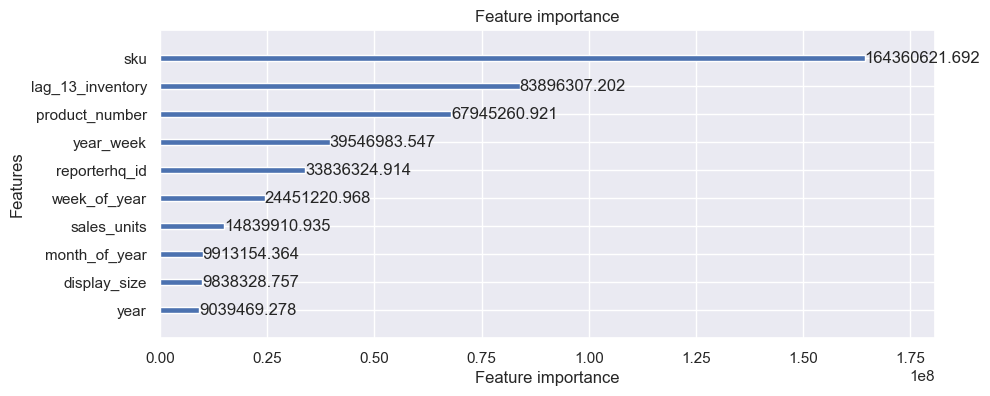

In [44]:
# Plot the feature importance based on "gain" (how much each feature improves the model)
lgb.plot_importance(model, importance_type='gain', max_num_features=10, figsize=(10, 4))
plt.show()

In [45]:
importance_split = model.booster_.feature_importance(importance_type='split')
importance_gain = model.booster_.feature_importance(importance_type='gain')

# Feature names from the model
features = model.feature_name_

importance_df = pd.DataFrame({
    'Feature': features,
    'Importance (Split)': importance_split,
    'Importance (Gain)': importance_gain
}).sort_values(by='Importance (Gain)', ascending=False)

print(importance_df)

             Feature  Importance (Split)  Importance (Gain)
7                sku                1407       1.643606e+08
13  lag_13_inventory                 926       8.389631e+07
1     product_number                 944       6.794526e+07
0          year_week                1000       3.954698e+07
2      reporterhq_id                 322       3.383632e+07
10      week_of_year                1125       2.445122e+07
6        sales_units                 808       1.483991e+07
11     month_of_year                 333       9.913154e+06
4       display_size                 190       9.838329e+06
12              year                 248       9.039469e+06
3      prod_category                  79       8.010364e+06
8       day_of_month                 397       1.355603e+06
9      week_of_month                 141       3.417018e+05
5            segment                   0       0.000000e+00


## Train/Test

Predict the inventory for the last 13 weeks

In [0]:
# Sort the dataframe by 'date' column in descending order to get the most recent dates
df_kaggle_model = df_kaggle_model.sort_values(by='date', ascending=True)

# Get the 13 largest (most recent) dates
top_13_dates = df_kaggle_model['date'].unique()[-13:]

# Create a new column sample and assign 'test' where the date is in the top 13 dates, else 'train'
df_kaggle_model['sample'] = df_kaggle_model['date'].apply(lambda x: 'test' if x in top_13_dates else 'train')

# Show
top_13_dates

<DatetimeArray>
['2023-05-06 00:00:00', '2023-04-29 00:00:00', '2023-04-22 00:00:00',
 '2023-04-15 00:00:00', '2023-04-08 00:00:00', '2023-04-01 00:00:00',
 '2023-03-25 00:00:00', '2023-03-18 00:00:00', '2023-03-11 00:00:00',
 '2023-03-04 00:00:00', '2023-02-25 00:00:00', '2023-02-18 00:00:00',
 '2023-02-11 00:00:00']
Length: 13, dtype: datetime64[ns]

In [43]:
X_train.columns

Index(['year_week', 'product_number', 'reporterhq_id', 'prod_category',
       'display_size', 'segment', 'sales_units', 'sku', 'day_of_month',
       'week_of_month', 'week_of_year', 'month_of_year', 'year',
       'lag_13_inventory'],
      dtype='object')

In [44]:
n_fold = 3 
folds = TimeSeriesSplit(n_splits=n_fold)

In [ ]:
x = X_train.copy()
y = y_train.copy()
test = data[(data['date'] > '2016-04-24')]
x = x.sort_values('date')
test = test.sort_values('date')

In [ ]:
columns = X_train.columns
splits = folds.split(x, y)
y_preds = np.zeros(test.shape[0])
y_oof = np.zeros(x.shape[0])
feature_importances = pd.DataFrame()
feature_importances['feature'] = columns
mean_score = []
for fold_n, (train_index, valid_index) in enumerate(splits):
    print('Fold:',fold_n+1)
    X_train, X_valid = x[columns].iloc[train_index], x[columns].iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)
    clf = lgb.train(params, dtrain, 2500, valid_sets = [dtrain, dvalid],early_stopping_rounds = 50, verbose_eval=100)
    feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()
    y_pred_valid = clf.predict(X_valid,num_iteration=clf.best_iteration)
    y_oof[valid_index] = y_pred_valid
    val_score = np.sqrt(metrics.mean_squared_error(y_pred_valid, y_valid))
    print(f'val rmse score is {val_score}')
    mean_score.append(val_score)
    y_preds += clf.predict(test[columns], num_iteration=clf.best_iteration)/n_fold
    del X_train, X_valid, y_train, y_valid
    gc.collect()
print('mean rmse score over folds is',np.mean(mean_score))
test['demand'] = y_preds

## Predictions

Train the model and generate predictions

In [0]:
# Set target
target = 'inventory_units'

In [0]:
# Add code here

# Evaluation

## Metrics

In [0]:
# Add code here